In [8]:
import numpy as np
import random as rand
import random
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from dataclasses import dataclass
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Cell Information

Biomass $\textit{biomass: float} \rightarrow$ The amount of biomass at a particular cell \
Burn Status $\textit{on_fire: bool} \rightarrow$ Whether or not a particular cell is burning

In [12]:
@dataclass
class Cell:
    """Class for keeping track of an information in a cell."""
    biomass: float
    on_fire: bool
        
    def __init__(self, biomass="", on_fire=False):
        self.biomass = biomass
        self.on_fire = on_fire
    
    def calculate_distribution(self):
        """
        Calculates the probability distribution for fire spread to neighboring cells based on current cell parameters.
        """
        pass

class Normal(Cell):
    """Normal cell class"""
    def calculate_distribution(self):
        pass

class HRB(Cell):
    """HRB cell class"""
    def calculate_distribution(self):
        pass
    
class Log(Cell):
    """Logged cell class"""
    def calculate_distribution(self):
        pass
    
class Env:
    """Environment class"""
    size: int
        
    def __init__(self, size: int):
        self.size = size
        self.map = np.array([[random.choice(TYPES)(0.0, bool(random.getrandbits(1))) for _ in range(self.size)] \
                             for _ in range(self.size)], dtype=object)
        self.curr_burn = set() #locations of currently burning cells
    
    def simulate(self):
        #for i in size:
        #    for j in size:
        #        local_spread()
        #        nonlocal_spread()
        pass
    
    def populate_state(self):
        ret = np.array([[0 for _ in range(self.size)] for _ in range(self.size)])
        for i in range(self.size):
            for j in range(self.size):
                if isinstance(self.map[i, j], Normal):
                    ret[i, j] = 0
                elif isinstance(self.map[i, j], HRB):
                    ret[i, j] = 1
                elif isinstance(self.map[i, j], Log):
                    ret[i, j] = 2
        return ret
    
    def plot_simulations(self, t=0):
        # create discrete colormap
        curr_state = self.populate_state()
        terrain_colors = colors.ListedColormap(['#24422c', '#4a8a5b', '#aab560'])
        fig, ax = plt.subplots()
        ax.imshow(curr_state, cmap=terrain_colors)
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
        plt.axis('off')
        plt.figtext(0.5, 0.01, "Land map at time t = " + str(t), wrap=True, horizontalalignment='center', fontsize=10)
        plt.show()

## Constants

B $\rightarrow$ rate of biomass decay \
SIZE $\rightarrow$ dimension of environment \
TIME $\rightarrow$ Number of time steps to simulate 

In [14]:
B = 0.05
TYPES = [HRB, Normal, Log]
C = HRB(0.0, False)
test = Env(100)

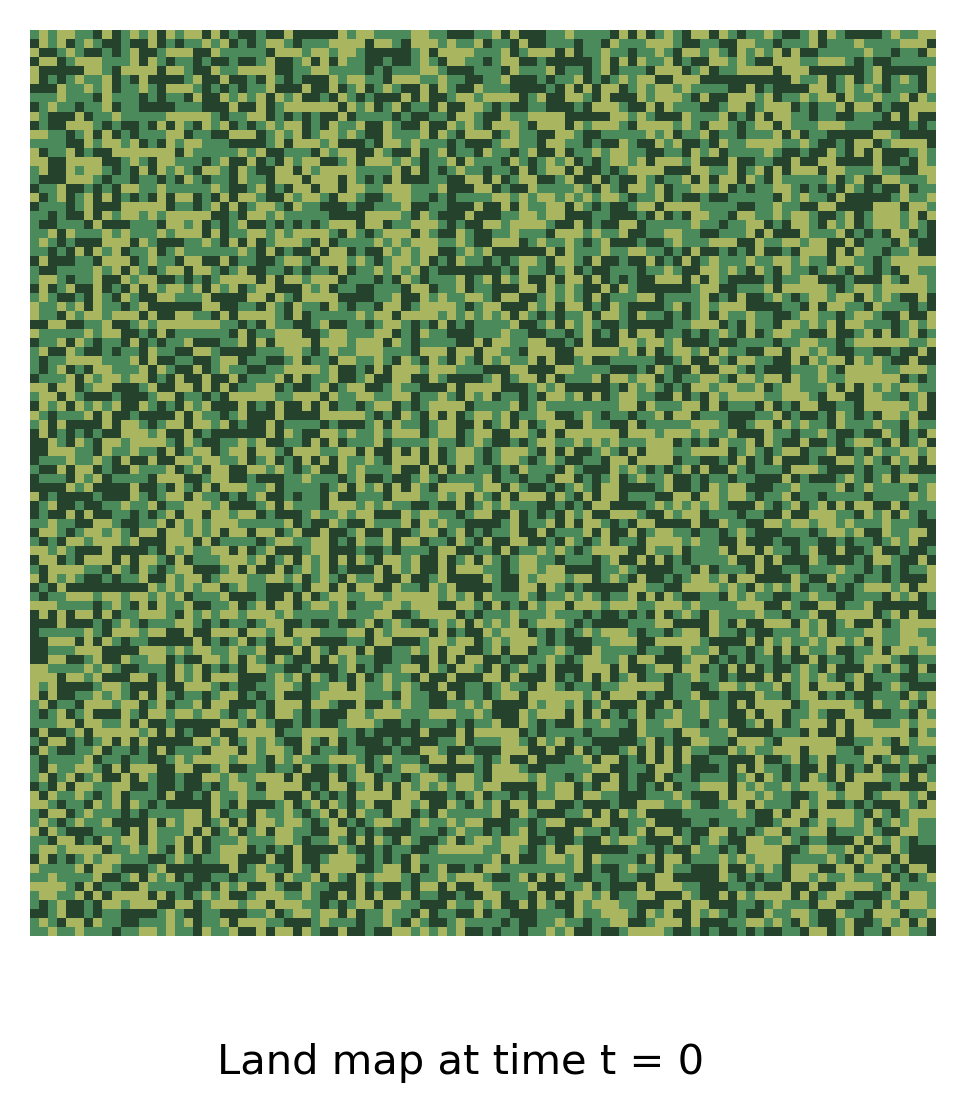

In [15]:
test.populate_state()
test.plot_simulations()